In [1]:
import torch
# GPU 사용 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))

# CUDA 사용 가능 여부 확인
print(f"CUDA available: {torch.cuda.is_available()}")  # True여야 함

# PyTorch에서 사용하는 CUDA 버전 확인
print(f"CUDA version in PyTorch: {torch.version.cuda}")

cuda
NVIDIA GeForce RTX 4050 Laptop GPU
CUDA available: True
CUDA version in PyTorch: 11.8


In [7]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F

이미지 증강 없이 훈련 진행해보기.  
적절한 모델은 어떻게 찾을까?  
데이터의 특성  
1. 결함 종류가 이물질, 오픈 회로, 광없음, 미부착, 미부식, 먼지, 핀홀, 밀착, 레이저로 인해 생긴 미세 구멍, 작은 긁힘, 섬, 잘못된 납땜,  
두 전기 회로의 의도치 않은 연결로 인한 단락현상, PCB 기반의 패턴이 잘못 인쇄되어 아래층이 비치는 현상, 표면에 균열 / 긁힘 등이 있는 현상, 스크래치가 있는 현상 등으로 다양하다.  
2. 결함 이미지가 1840개, 정상 이미지가 1240개로 총 3180개의 소규모 이미지 데이터 세트이다.  

[계획]  
1. 간단한 CNN 모델을 만들어서 훈련을 진행.  
2. 모델의 성능이 좋지 않다면 사전 훈련 모델을 사용해서 모델 학습을 진행.    
3. 데이터의 과적합이 발생한다면, 데이터 증강 또는 오버샘플링 등을 적용해보자.  

In [18]:
from torchvision import datasets
import pandas as pd

IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # 이미지를 Tensor로 변환 (0~255 범위를 0~1 범위로 정규화)
])

# 데이터셋 디렉토리 설정
train_dir = '../PCB_imgs/all/resize/train'
val_dir = '../PCB_imgs/all/resize/validation'
test_dir = '../PCB_imgs/all/resize/test'

# ImageFolder로 데이터셋 불러오기
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# 파일 경로 및 타겟 추출
train_file_paths = [img[0] for img in train_dataset.imgs]
train_targets = train_dataset.targets

val_file_paths = [img[0] for img in val_dataset.imgs]
val_targets = val_dataset.targets

test_file_paths = [img[0] for img in test_dataset.imgs]
test_targets = test_dataset.targets

# DataFrame 생성
train_df = pd.DataFrame({'file_paths': train_file_paths, 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': val_file_paths, 'targets': val_targets})
test_df = pd.DataFrame({'file_paths': test_file_paths, 'targets': test_targets})

# 확인을 위해 각 데이터셋의 크기 출력
print(f"Train 데이터 수: {len(train_df)}")
print(f"Validation 데이터 수: {len(validation_df)}")
print(f"Test 데이터 수: {len(test_df)}")

Train 데이터 수: 2008
Validation 데이터 수: 502
Test 데이터 수: 628


In [19]:
import torch
from torchvision import datasets, transforms

# resize된 데이터셋 로드
input_dir = '../PCB_imgs/all/resize/'
dataset = datasets.ImageFolder(root=input_dir, transform=transform)

# 데이터 로더 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 데이터 로더에서 데이터 가져오기
for images, labels in dataloader:
    print(images.shape)  # 배치의 이미지 텐서 크기 확인
    break  # 첫 번째 배치만 확인
    # 배치 크기, 채널 수(RGB), 이미지 크기 

torch.Size([32, 3, 256, 256])


In [20]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  # 크기 조정

        if self.aug is not None:
            image = self.aug(image=image)['image']  # 데이터 증강 적용

        if self.preprocess is not None:
            image = self.preprocess(image)  # 추가적인 전처리 적용

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W) 변환
        image = torch.tensor(image, dtype=torch.float32)  # 텐서로 변환

        return image, target

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 10

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 칼라이미지 -> 입력 채널 수: 3
        # 출력 채널 수: 16(지정가능)
        # window size : 3 * 3 슬라이딩
        # stride: default가 1칸
        # padding: 1(지정)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        # 2 * 2 필터 사용하여 풀링, stride=2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        # 32: 채널수
        # 64: 풀링 이후 높이와 넓이
        # 128: 차원
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 1)  # 두 번째 완전 연결 층 (이진 분류 이므로 1)

    def forward(self, x):
        # conv1 -> ReLU -> pool1
        x = self.pool(F.relu(self.conv1(x)))  # 첫 번째 합성곱 + 활성화 + 풀링
        # conv2 -> ReLU -> pool2
        x = self.pool(F.relu(self.conv2(x)))  # 두 번째 합성곱 + 활성화 + 풀링
        # 64 * 64 피쳐맵 32개를 일렬로 만든다(Flatten)
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = F.relu(self.fc1(x))  # 첫 번째 완전 연결 층 + 활성화
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(DEVICE)  # 모델을 적절한 장치로 이동
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [49]:
# 평가 함수 정의
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).float()
            outputs = model(images)
            outputs = outputs.squeeze(1)
            # outputs = outputs.view(-1) # torch.Size([batch_size])로 변환
            loss = criterion(outputs, labels)  # 손실 계산
            running_test_loss += loss.item()
            
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # 0.5 기준으로 이진 분류
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    # 검증 손실과 정확도
    test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test
    return test_loss, test_accuracy

In [42]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).float()
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        outputs = outputs.squeeze(1)  # [batch_size, 1] -> [batch_size]로 변환
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        # 훈련 손실 누적
        running_loss += loss.item()

        # 예측값 계산 (0.5 기준 이진 분류)
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        # 정확도 계산
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실 및 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # 검증 손실 및 정확도 평가
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')


Epoch [1/10], Train Loss: 0.0682, Train Accuracy: 0.98, Validation Loss: 0.4003, Validation Accuracy: 0.86
Epoch [2/10], Train Loss: 0.0279, Train Accuracy: 1.00, Validation Loss: 0.4705, Validation Accuracy: 0.86
Epoch [3/10], Train Loss: 0.0182, Train Accuracy: 1.00, Validation Loss: 0.4034, Validation Accuracy: 0.87
Epoch [4/10], Train Loss: 0.0117, Train Accuracy: 1.00, Validation Loss: 0.5299, Validation Accuracy: 0.87
Epoch [5/10], Train Loss: 0.0063, Train Accuracy: 1.00, Validation Loss: 0.5038, Validation Accuracy: 0.87
Epoch [6/10], Train Loss: 0.0047, Train Accuracy: 1.00, Validation Loss: 0.5466, Validation Accuracy: 0.87
Epoch [7/10], Train Loss: 0.0024, Train Accuracy: 1.00, Validation Loss: 0.5699, Validation Accuracy: 0.87
Epoch [8/10], Train Loss: 0.0016, Train Accuracy: 1.00, Validation Loss: 0.5651, Validation Accuracy: 0.87
Epoch [9/10], Train Loss: 0.0012, Train Accuracy: 1.00, Validation Loss: 0.5769, Validation Accuracy: 0.86
Epoch [10/10], Train Loss: 0.0009, Tr

In [ ]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}')

#### 간단한 cnn 모델로 훈련한 결과  
훈련 데이터에 과적합된 결과 확인.  

- 이를 해결하기 위해 dropout, batch normalization 사용

In [51]:
# 과적합을 없애보기 위한 과정1: dropout, batch normalization 사용

# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 20

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization 추가
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        self.dropout = nn.Dropout(0.3)  # Dropout 층 추가
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 1)  # 두 번째 완전 연결 층 (이진 분류 이므로 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 첫 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 두 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = self.dropout(F.relu(self.fc1(x)))  # 첫 번째 완전 연결 층 + 활성화 + Dropout
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(DEVICE)  # 모델을 적절한 장치로 이동
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [52]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).float()
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        outputs = outputs.squeeze(1)  # [batch_size, 1] -> [batch_size]로 변환
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        # 훈련 손실 누적
        running_loss += loss.item()

        # 예측값 계산 (0.5 기준 이진 분류)
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        # 정확도 계산
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실 및 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # 검증 손실 및 정확도 평가
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')


Epoch [1/20], Train Loss: 4.0734, Train Accuracy: 0.67, Validation Loss: 0.4563, Validation Accuracy: 0.74
Epoch [2/20], Train Loss: 0.4172, Train Accuracy: 0.78, Validation Loss: 0.4032, Validation Accuracy: 0.82
Epoch [3/20], Train Loss: 0.4027, Train Accuracy: 0.80, Validation Loss: 0.3835, Validation Accuracy: 0.80
Epoch [4/20], Train Loss: 0.3576, Train Accuracy: 0.80, Validation Loss: 0.3393, Validation Accuracy: 0.85
Epoch [5/20], Train Loss: 0.3215, Train Accuracy: 0.84, Validation Loss: 0.3553, Validation Accuracy: 0.87
Epoch [6/20], Train Loss: 0.2841, Train Accuracy: 0.86, Validation Loss: 0.3010, Validation Accuracy: 0.87
Epoch [7/20], Train Loss: 0.2776, Train Accuracy: 0.86, Validation Loss: 0.3295, Validation Accuracy: 0.89
Epoch [8/20], Train Loss: 0.2630, Train Accuracy: 0.89, Validation Loss: 0.3720, Validation Accuracy: 0.88
Epoch [9/20], Train Loss: 0.2257, Train Accuracy: 0.90, Validation Loss: 0.3762, Validation Accuracy: 0.86
Epoch [10/20], Train Loss: 0.2169, Tr

In [44]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}')

Test Loss: 0.9846, Test Accuracy: 0.86


#### 간단한 cnn + dropout + batch normalization 사용 결과:  
여전히 과적합된 모델 확인.  

- l2 규제 사용

In [53]:
# 과적합을 없애보기 위한 과정2: dropout, batch normalization + l2규제 사용

# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 20

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization 추가
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        self.dropout = nn.Dropout(0.3)  # Dropout 층 추가
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 1)  # 두 번째 완전 연결 층 (이진 분류 이므로 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 첫 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 두 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = self.dropout(F.relu(self.fc1(x)))  # 첫 번째 완전 연결 층 + 활성화 + Dropout
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(DEVICE)  # 모델을 적절한 장치로 이동
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  # L2 정규화 추가

In [54]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).float()
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        outputs = outputs.squeeze(1)  # [batch_size, 1] -> [batch_size]로 변환
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        # 훈련 손실 누적
        running_loss += loss.item()

        # 예측값 계산 (0.5 기준 이진 분류)
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        # 정확도 계산
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실 및 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # 검증 손실 및 정확도 평가
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')


Epoch [1/20], Train Loss: 2.9783, Train Accuracy: 0.71, Validation Loss: 0.4348, Validation Accuracy: 0.77
Epoch [2/20], Train Loss: 0.3891, Train Accuracy: 0.80, Validation Loss: 0.3524, Validation Accuracy: 0.83
Epoch [3/20], Train Loss: 0.3401, Train Accuracy: 0.84, Validation Loss: 0.3192, Validation Accuracy: 0.87
Epoch [4/20], Train Loss: 0.3017, Train Accuracy: 0.86, Validation Loss: 0.3049, Validation Accuracy: 0.87
Epoch [5/20], Train Loss: 0.2449, Train Accuracy: 0.89, Validation Loss: 0.3160, Validation Accuracy: 0.86
Epoch [6/20], Train Loss: 0.2230, Train Accuracy: 0.90, Validation Loss: 0.3279, Validation Accuracy: 0.87
Epoch [7/20], Train Loss: 0.2501, Train Accuracy: 0.88, Validation Loss: 0.2886, Validation Accuracy: 0.87
Epoch [8/20], Train Loss: 0.2254, Train Accuracy: 0.88, Validation Loss: 0.3348, Validation Accuracy: 0.87
Epoch [9/20], Train Loss: 0.1918, Train Accuracy: 0.90, Validation Loss: 0.3207, Validation Accuracy: 0.87
Epoch [10/20], Train Loss: 0.1746, Tr

In [55]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}')

Test Loss: 0.4338, Test Accuracy: 0.87


데이터 증강 적용

In [56]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),                # 좌우 반전
    A.VerticalFlip(p=0.5),                  # 상하 반전
    A.Rotate(limit=10, p=0.5),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [57]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN().to(DEVICE) 
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [58]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).float()
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        outputs = outputs.squeeze(1)  # [batch_size, 1] -> [batch_size]로 변환
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        # 훈련 손실 누적
        running_loss += loss.item()

        # 예측값 계산 (0.5 기준 이진 분류)
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        # 정확도 계산
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실 및 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # 검증 손실 및 정확도 평가
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')

Epoch [1/20], Train Loss: 3.9362, Train Accuracy: 0.67, Validation Loss: 0.4816, Validation Accuracy: 0.75
Epoch [2/20], Train Loss: 0.4366, Train Accuracy: 0.73, Validation Loss: 0.3997, Validation Accuracy: 0.77
Epoch [3/20], Train Loss: 0.3797, Train Accuracy: 0.78, Validation Loss: 0.3541, Validation Accuracy: 0.80
Epoch [4/20], Train Loss: 0.3304, Train Accuracy: 0.80, Validation Loss: 0.4200, Validation Accuracy: 0.76
Epoch [5/20], Train Loss: 0.3158, Train Accuracy: 0.81, Validation Loss: 0.3351, Validation Accuracy: 0.83
Epoch [6/20], Train Loss: 0.2871, Train Accuracy: 0.85, Validation Loss: 0.3518, Validation Accuracy: 0.83
Epoch [7/20], Train Loss: 0.2492, Train Accuracy: 0.87, Validation Loss: 0.3687, Validation Accuracy: 0.85
Epoch [8/20], Train Loss: 0.2297, Train Accuracy: 0.89, Validation Loss: 0.3016, Validation Accuracy: 0.88
Epoch [9/20], Train Loss: 0.1996, Train Accuracy: 0.90, Validation Loss: 0.3353, Validation Accuracy: 0.89
Epoch [10/20], Train Loss: 0.2060, Tr

In [59]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}')

Test Loss: 0.3304, Test Accuracy: 0.88


#### 간단한 cnn + 데이터 증강 적용 결과:  
검증데이터의 손실값이 줄어드는 추세!  
epoch를 더 늘려보자. 그 대신 과적합 방지를 위해 학습률 스케줄러와 조기 중단을 적용해보기.

In [76]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN().to(DEVICE) 
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [75]:
EPOCHS = 50
LEARNING_RATE = 0.001

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).float()
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        outputs = outputs.squeeze(1)  # [batch_size, 1] -> [batch_size]로 변환
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        # 훈련 손실 누적
        running_loss += loss.item()

        # 예측값 계산 (0.5 기준 이진 분류)
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        # 정확도 계산
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실 및 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # 검증 손실 및 정확도 평가
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 2.0654, Train Accuracy: 0.7201, Validation Loss: 0.4401, Validation Accuracy: 0.8108
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.4160, Train Accuracy: 0.8108, Validation Loss: 0.3287, Validation Accuracy: 0.8606
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.3294, Train Accuracy: 0.8441, Validation Loss: 0.2973, Validation Accuracy: 0.8765
Epoch [4/50], Train Loss: 0.3254, Train Accuracy: 0.8441, Validation Loss: 0.3235, Validation Accuracy: 0.8466
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.2941, Train Accuracy: 0.8655, Validation Loss: 0.2918, Validation Accuracy: 0.8825
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.2182, Train Accuracy: 0.9064, Validation Loss: 0.2780, Validation Accuracy: 0.8865
Epoch [7/50], Train Loss: 0.2414, Train Accuracy: 0.8919, Validation Loss: 0.2894, Validation Accuracy: 0.8845
Epoch [8/50],

In [77]:
EPOCHS = 50
LEARNING_RATE = 0.001

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 2.8278, Train Accuracy: 0.6703, Val Loss: 0.5214, Val Accuracy: 0.7570
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.4929, Train Accuracy: 0.7555, Val Loss: 0.4380, Val Accuracy: 0.7629
Epoch [3/50], Train Loss: 0.4272, Train Accuracy: 0.7644, Val Loss: 0.5462, Val Accuracy: 0.7450
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.4012, Train Accuracy: 0.7774, Val Loss: 0.4073, Val Accuracy: 0.7749
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.3656, Train Accuracy: 0.7878, Val Loss: 0.3732, Val Accuracy: 0.7490
Epoch [6/50], Train Loss: 0.3498, Train Accuracy: 0.7973, Val Loss: 0.3963, Val Accuracy: 0.7908
Validation loss improved, saving model...
Epoch [7/50], Train Loss: 0.3136, Train Accuracy: 0.8123, Val Loss: 0.3643, Val Accuracy: 0.7928
Epoch [8/50], Train Loss: 0.2723, Train Accuracy: 0.8282, Val Loss: 0.5722, Val Accuracy: 0.7311
Validation los

In [78]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}')

Test Loss: 0.3523, Test Accuracy: 0.86


오버샘플링 시도  
(NG: 1840, OK: 1240) 

In [123]:
import os
from PIL import Image 

class OverSamplingDataset(Dataset):
    def __init__(self, ng_dir, ok_dir, transform=None):
        self.ng_images = [os.path.join(ng_dir, img) for img in os.listdir(ng_dir)]
        self.ok_images = [os.path.join(ok_dir, img) for img in os.listdir(ok_dir)]
        self.transform = transform

        # NG 이미지 수와 OK 이미지 수 출력
        print(f'NG 이미지 수: {len(self.ng_images)}')
        print(f'OK 이미지 수: {len(self.ok_images)}')

        # OK 이미지를 NG 이미지 수 만큼 반복하여 오버샘플링
        self.ok_images = self.ok_images * (len(self.ng_images) // len(self.ok_images)) + self.ok_images[:len(self.ng_images) % len(self.ok_images)]

        # 오버샘플링 후 OK 이미지 수가 830이 되도록 맞춤
        self.ok_images = self.ok_images[:len(self.ng_images)]  # NG와 동일한 수로 제한

        # 최종 데이터셋은 NG와 OK 이미지의 합
        self.images = self.ng_images + self.ok_images
        self.labels = [0] * len(self.ng_images) + [1] * len(self.ok_images)  # NG=0, OK=1

        # 최종 이미지와 레이블 수 출력
        print(f'오버샘플링 후 NG 이미지 수: {len(self.ng_images)}')
        print(f'오버샘플링 후 OK 이미지 수: {len(self.ok_images)}')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")  # PIL 이미지로 열기
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# 데이터셋 인스턴스 생성
train_dataset = OverSamplingDataset(ng_dir='../PCB_imgs/all/resize/train/NG/', ok_dir='../PCB_imgs/all/resize/train/OK/', transform=transform)
validation_dataset = datasets.ImageFolder(root=val_dir, transform=transform)  # 검증, 테스트 데이터는 그대로 사용
test_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

NG 이미지 수: 1178
OK 이미지 수: 830
오버샘플링 후 NG 이미지 수: 1178
오버샘플링 후 OK 이미지 수: 1178


In [124]:
# dropout, batch normalization + l2규제 사용

# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 20
DROPOUT_RATE = 0.5  # Dropout 비율 설정

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization 추가
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        self.dropout = nn.Dropout(DROPOUT_RATE)  # Dropout 층 추가
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 1)  # 두 번째 완전 연결 층 (이진 분류 이므로 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 첫 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 두 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = self.dropout(F.relu(self.fc1(x)))  # 첫 번째 완전 연결 층 + 활성화 + Dropout
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(DEVICE)  # 모델을 적절한 장치로 이동
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  # L2 정규화 추가

In [111]:
EPOCHS = 50
LEARNING_RATE = 0.001

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 10  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 2.4107, Train Accuracy: 0.6791, Val Loss: 0.4165, Val Accuracy: 0.7649
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.4690, Train Accuracy: 0.7453, Val Loss: 0.3727, Val Accuracy: 0.8147
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.4488, Train Accuracy: 0.7343, Val Loss: 0.3431, Val Accuracy: 0.8227
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.4077, Train Accuracy: 0.7572, Val Loss: 0.3303, Val Accuracy: 0.8386
Epoch [5/50], Train Loss: 0.3833, Train Accuracy: 0.7924, Val Loss: 0.3378, Val Accuracy: 0.8725
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.3654, Train Accuracy: 0.8171, Val Loss: 0.2986, Val Accuracy: 0.8765
Epoch [7/50], Train Loss: 0.3300, Train Accuracy: 0.8383, Val Loss: 0.3165, Val Accuracy: 0.8825
Epoch [8/50], Train Loss: 0.3208, Train Accuracy: 0.8166, Val Loss: 0.5595, Val Accuracy: 0.7590
Epoch [9/50], 

In [112]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.4186, Test Accuracy: 0.8865


In [113]:
# 모델 저장
torch.save(model.state_dict(), '../model/CNN_model.pth')

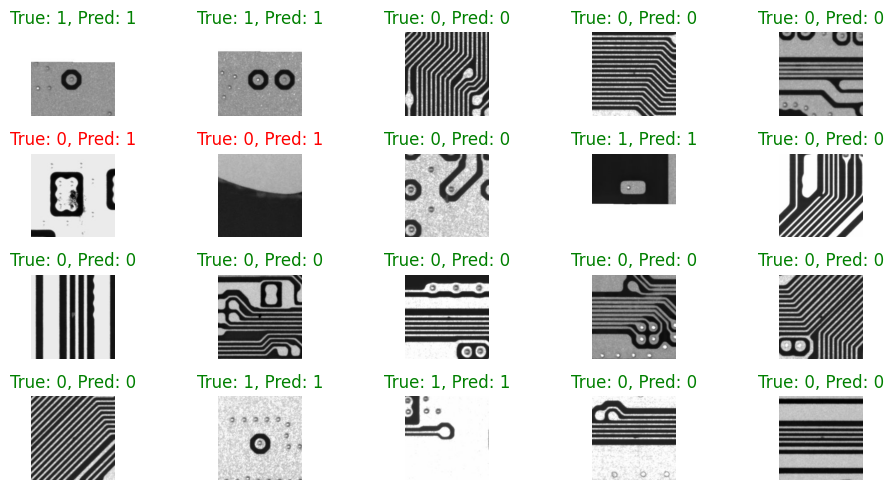

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# 테스트 데이터셋에서 무작위로 20개의 샘플을 선택하는 함수
def get_random_samples(dataset, num_samples=20):
    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]
    return samples, indices

# 이미지 시각화 및 예측 결과 표시
def visualize_predictions(model, dataset, num_samples=20):
    # 모델을 평가 모드로 전환
    model.eval()
    
    # 무작위로 10개의 샘플 가져오기
    samples, indices = get_random_samples(dataset, num_samples=num_samples)
    
    fig, axs = plt.subplots(4, 5, figsize=(10, 5))
    axs = axs.ravel()
    
    with torch.no_grad():
        for i, (image, label) in enumerate(samples):
            # 이미지와 레이블 준비
            image_input = image.unsqueeze(0).to(DEVICE)  # 배치 차원 추가 및 장치로 이동
            label = label
            
            # 예측 수행
            output = model(image_input)
            pred = torch.sigmoid(output).item()
            pred_label = 1 if pred > 0.5 else 0
            
            # 이미지를 numpy로 변환하여 시각화
            image_np = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
            image_np = (image_np * 255).astype(np.uint8)  # [0, 1] 범위에서 [0, 255] 범위로 변환
            
            # 정답/오답에 따른 레이블 색상 결정
            if pred_label == label:
                color = 'green'  # 정답일 때 녹색
            else:
                color = 'red'  # 오답일 때 빨간색

            # 이미지 및 레이블 출력
            axs[i].imshow(image_np)
            axs[i].set_title(f"True: {label}, Pred: {pred_label}", color=color)
            axs[i].axis('off')  # 축 제거
    
    plt.tight_layout()
    plt.show()

# 모델을 사용하여 테스트 데이터에서 무작위 20개 샘플 예측 및 시각화
visualize_predictions(model, test_dataset)

직접 만든 CNN 모델 훈련은 여기까지 진행하고 다른 모델을 사용해보는 것이 좋을 것 같다.  
데이터가 많지 않은 상황. 데이터 증강 및 오버샘플링을 시도하였으나 성능이 0.9정도로 확인됨.  
사전훈련 모델을 사용하여 전이 학습(Transfer Learning)을 진행해보는 것이 모델 성능 향상에 좋을 것이라 예상됨.   

In [125]:
EPOCHS = 50
LEARNING_RATE = 0.001

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/50], Train Loss: 2.0108, Train Accuracy: 0.6638, Val Loss: 0.4328, Val Accuracy: 0.7510
Epoch [2/50], Train Loss: 0.4578, Train Accuracy: 0.7598, Val Loss: 0.3816, Val Accuracy: 0.8147
Epoch [3/50], Train Loss: 0.4284, Train Accuracy: 0.7823, Val Loss: 0.4562, Val Accuracy: 0.7211
Epoch [4/50], Train Loss: 0.4255, Train Accuracy: 0.7750, Val Loss: 0.3517, Val Accuracy: 0.8227
Epoch [5/50], Train Loss: 0.3811, Train Accuracy: 0.7924, Val Loss: 0.3358, Val Accuracy: 0.8367
Epoch [6/50], Train Loss: 0.3677, Train Accuracy: 0.7946, Val Loss: 0.3656, Val Accuracy: 0.7789
Epoch [7/50], Train Loss: 0.3463, Train Accuracy: 0.8171, Val Loss: 0.3722, Val Accuracy: 0.7749
Epoch [8/50], Train Loss: 0.3806, Train Accuracy: 0.8005, Val Loss: 0.3441, Val Accuracy: 0.8167
Epoch [9/50], Train Loss: 0.3597, Train Accuracy: 0.8128, Val Loss: 0.3921, Val Accuracy: 0.8665
Epoch [10/50], Train Loss: 0.2866, Train Accuracy: 0.8519, Val Loss: 0.3075, Val Accuracy: 0.8845
Epoch [11/50], Train Loss: 0.